# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.session import Session
from sagemaker import get_execution_role


role = get_execution_role()
region = sagemaker.Session().boto_region_name
bucket = sagemaker.Session().default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-300528681364


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-04-13 11:27:52--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  33.4MB/s    in 36s     

2023-04-13 11:28:31 (30.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [5]:
prefix ="dogImagesDataset"
input_path = sagemaker.Session().upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {input_path}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-300528681364/dogImagesDataset


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
#TODO: Declare your HP ranges, metrics etc

#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [11]:
#TODO: Create estimators for your HPs

# estimator = 
# TODO: Your estimator here

# tuner = 
# TODO: Your HP tuner 

from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py3",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [12]:
# TODO: Fit your HP Tuner
# tuner.fit() 
# TODO: Remember to include your data channels

tuner.fit({"training": input_path }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................!


In [16]:
# TODO: Get the best estimators and the best HPs

# best_estimator = #TODO
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-04-14 22:40:34 Starting - Preparing the instances for training
2023-04-14 22:40:34 Downloading - Downloading input data
2023-04-14 22:40:34 Training - Training image download completed. Training in progress.
2023-04-14 22:40:34 Uploading - Uploading generated training model
2023-04-14 22:40:34 Completed - Resource reused by training job: pytorch-training-230414-2230-004-5cd8d1e6


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'eps': '3.972559626859065e-09',
 'lr': '0.0001471610534166238',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2023-04-14-22-30-14-610"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-300528681364/dog-breed-classification-hpo-2023-04-14-22-30-14-610/source/sourcedir.tar.gz"',
 'weight_decay': '0.005026032640569199'}

In [17]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 64, 'eps': '3.972559626859065e-09', 'lr': '0.0001471610534166238', 'weight_decay': '0.005026032640569199'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [18]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [21]:
# TODO: Create and fit an estimator

# estimator = # TODO: Your estimator here

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.8", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py3",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

In [22]:
estimator.fit({'train' : input_path },wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-14-22-51-01-552


2023-04-14 22:51:04 Starting - Starting the training job...
2023-04-14 22:51:20 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-04-14 22:52:12 Downloading - Downloading input data......
2023-04-14 22:53:07 Training - Downloading the training image........................
2023-04-14 22:57:09 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-14 22:57:10,530 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-14 22:57:10,564 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-14 22:57:10,568 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-14 22:57:10,843 sagemaker-training-toolkit I

In [23]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = boto3.client('sagemaker')
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2023-04-14-22-51-01-552
Client: <botocore.client.SageMaker object at 0x7f2499683dd0>
Description: {'TrainingJobName': 'pytorch-training-2023-04-14-22-51-01-552', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:300528681364:training-job/pytorch-training-2023-04-14-22-51-01-552', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'eps': '"3.972559626859065e-09"', 'lr': '"0.0001471610534166238"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2023-04-14-22-51-01-552"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/source/sourcedir.tar.gz"', 'weight_decay': '"0.005026032640569199"'}, 'AlgorithmSpecifi

In [24]:
# Define a Trail

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-14 23:04:38.584 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:4242 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-14 23:04:38.611 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:4242 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/debug-output


[2023-04-14 23:04:41.777 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:4242 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-14 23:04:42.799 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:4242 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


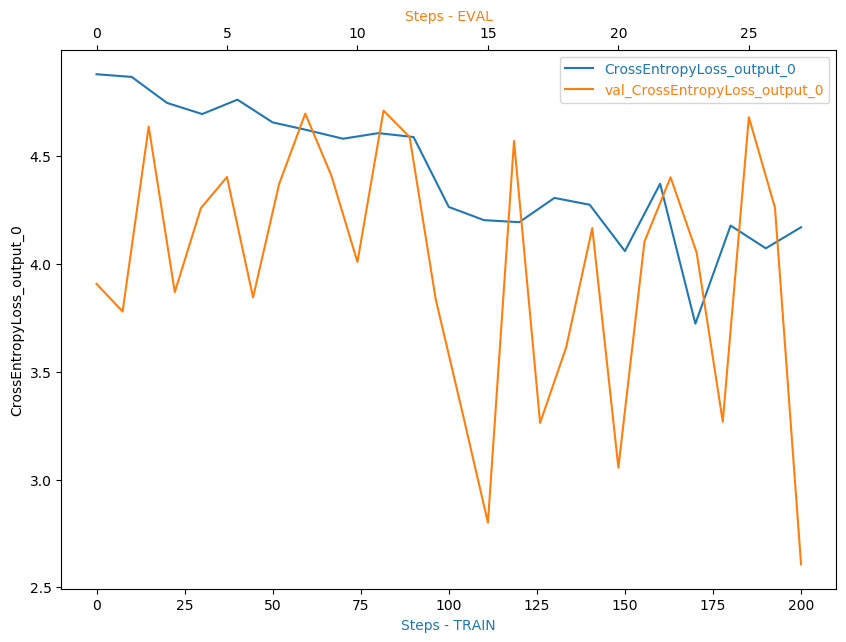

In [25]:
# TODO: Plot a debugging output.

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [26]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/rule-output


In [27]:
! aws s3 ls {rule_output_path} --recursive

2023-04-14 23:03:36     416168 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-14 23:03:35     270803 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-14 23:03:30        192 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-14 23:03:30      14625 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-14 23:03:30       2025 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-14 23:03:30        325 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-14 23:03:30       1322 pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-re

In [28]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-22-51-01-552/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-300528681364/pytorch-training-2023-04-14-

In [29]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [65]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [3]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_report.zip'

## Model Deploying

In [41]:
# TODO: Deploy your model to an endpoint
 # TODO: Add your deployment configuration like instance type and number of instances
# predictor=estimator.deploy()
# predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")
model_data_artifacts = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"

print(predictor.endpoint_name)

pytorch-inference-2023-04-14-23-50-05-649


In [37]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                            entry_point= "inference.py",
                            py_version = "py3",
                            framework_version = "1.8",
                            redictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-14-23-50-04-884
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-14-23-50-05-649
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-14-23-50-05-649


-------!

Test image no: 1
Below is the image that we will be testing:


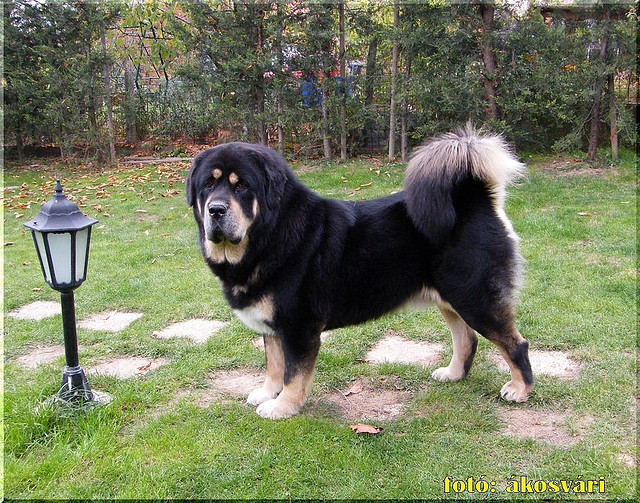

Expected dog breed category no : 129
Response: [[0.0, 0.7204068303108215, 0.0, 1.3154950141906738, 2.832400321960449, 0.0, 0.0, 0.0, 0.0, 0.868023157119751, 0.8616480827331543, 0.8980549573898315, 0.06623943150043488, 0.3388347029685974, 0.0, 0.0, 0.8903864622116089, 0.0, 0.0, 0.0, 0.0, 0.0, 0.946462094783783, 0.0, 0.11038219183683395, 0.0, 0.3624853193759918, 0.4418569803237915, 0.49874812364578247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07158739119768143, 0.0, 0.0, 0.0, 0.0, 0.029746510088443756, 0.13711465895175934, 0.0, 0.3420547544956207, 0.0, 0.0, 0.0, 0.0, 0.0, 1.103242039680481, 0.0, 0.5839999318122864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.236923098564148, 0.0, 0.0, 0.3063201308250427, 0.0, 0.0, 0.7841005921363831, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9744355082511902, 0.0, 0.0, 0.9826450347900391, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5103245973587036, 0.0, 0.0, 0.35119161009788513, 0.9346947073936462, 0.0, 0.0, 0.12491243332624435, 0.

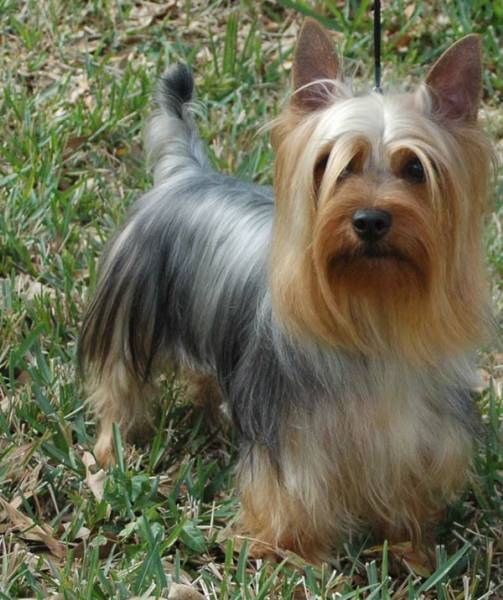

Expected dog breed category no : 127
Response: [[0.0, 0.47410324215888977, 0.5095945000648499, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.581885814666748, 0.5744664072990417, 2.7310829162597656, 0.43583619594573975, 0.0, 0.0, 1.827720284461975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9547663927078247, 0.0, 1.4187651872634888, 0.0, 0.0, 0.0, 0.2973680794239044, 0.0, 0.0, 0.0, 1.7608624696731567, 0.0, 0.0, 0.0, 1.9808077812194824, 0.0, 0.0, 0.0, 0.5801220536231995, 0.0, 1.7266007661819458, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6390351057052612, 0.0, 0.8336697220802307, 0.0, 1.4113448858261108, 0.0, 0.0, 0.20424319803714752, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32206180691719055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8533107042312622, 0.0, 0.0, 0.0, 0.0, 1.1656718254089355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8349846601486206, 0.0, 1.1462209224700928, 0.0, 0.8289973735809326, 0.5317783951759338, 0.0, 1.7528269290924072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052949227392

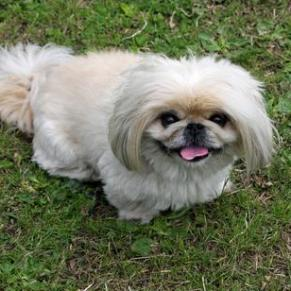

Expected dog breed category no : 117
Response: [[0.0, 0.03795170411467552, 0.0, 0.0, 0.27604085206985474, 0.9208438992500305, 0.0, 0.0, 0.0, 0.522121012210846, 0.0, 0.8085952997207642, 0.45421329140663147, 0.0, 0.0, 0.0, 1.59925377368927, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12186986207962036, 0.0, 0.0, 0.0, 2.460681676864624, 0.0, 1.0599743127822876, 0.0, 0.9715877771377563, 0.0, 0.0, 0.0, 2.398391008377075, 0.0, 0.8160889744758606, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2798287272453308, 0.0, 0.042414724826812744, 0.0, 0.6876700520515442, 0.0, 0.10772912949323654, 0.064008429646492, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21306347846984863, 0.0, 0.0, 0.0, 0.0, 0.1322007179260254, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3730149269104004, 0.0, 0.0, 1.719538688659668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5617589950561523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4011068046092987, 2.075343370437622, 0.0, 1.0187182426452637, 0.0, 0.0, 0.47590407729148865, 0.0, 0.4197084605693817, 

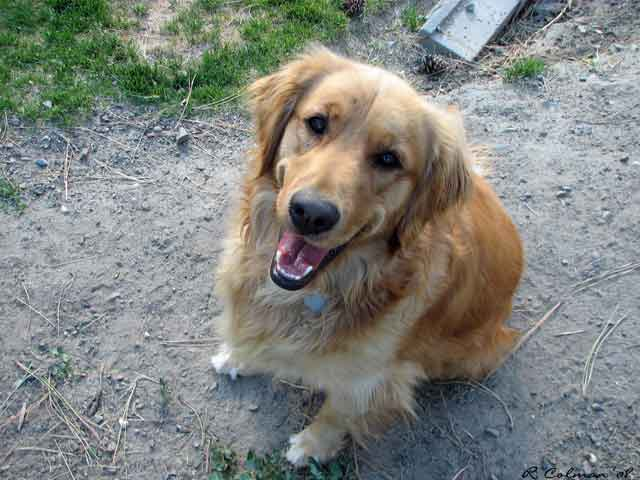

Expected dog breed category no : 76
Response: [[0.0, 0.4212081730365753, 0.26921454071998596, 0.42896002531051636, 0.45965608954429626, 0.0, 0.0, 0.0, 0.0, 0.9898062348365784, 0.0336613729596138, 0.5803323984146118, 0.4214194715023041, 0.0, 0.0, 0.0, 0.3913765251636505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05940134823322296, 0.0, 0.01741037331521511, 0.0, 0.5054193139076233, 0.0, 0.6134382486343384, 0.39262911677360535, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25281161069869995, 0.5532639026641846, 0.0, 0.42030736804008484, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8979113101959229, 0.2847609519958496, 1.0089068412780762, 0.0, 0.1705409735441208, 0.0, 0.0, 0.999582827091217, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9181621670722961, 0.0, 0.0, 0.7041594386100769, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6542876958847046, 0.0, 0.0, 0.0005554845556616783, 0.0, 0.0, 0.0, 0.0, 0.8576529622077942, 0.0, 0.10137034952640533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8029611110687256, 0.0, 0.24563556909561157, 0.916

In [44]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction
# image = 
# response = predictor.predict(image)

from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ 'Tibetan_mastiff_08140.jpg', 'Silky_terrier_08040.jpg', 'Pekingese_07568.jpg', 'Golden_retriever_05221.jpg' ]
test_images_expected_output = [129, 127, 117,76]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [48]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-14-23-50-05-649
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-14-23-50-05-649
